In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA

import plotly.graph_objects as go
import plotly.subplots as sp

import darts
from darts import TimeSeries
from darts.models import Prophet
from darts.metrics.metrics import mae
from darts.metrics.metrics import rmse
from darts.metrics.metrics import mape
from darts.metrics.metrics import mase
from darts.models import NaiveSeasonal
from darts.models import NaiveDrift
from darts.models import ARIMA
from darts.models import ExponentialSmoothing
from darts.models import Prophet
from darts.utils.utils import ModelMode, SeasonalityMode

## Time Series Forecasts with S&P 500 Index Price Data
---

Increase accuracy predicting stock price movements would obviously lead to more profitable investment strategies. This portion of the project seeks to explore the potential of time series analyses as a tool for forecasting the S&P 500 index price.

Time series analysis involves studying sequences of data points ordered in time to identify potential patterns and trends. In the context of stock price movements, these patterns can potentially reveal valuable insights about future price movements.

We will explore various models such as Naive forecasting techniques, ARIMA (Autoregressive Integrated Moving Average), Exponential Smoothing, and Prophet, an open-source tool released by Facebook’s Core Data Science team for forecasting time series data.

This research will initially leverage 10 years of historical S&P 500 index prices to build forecasting models to predict potential future price movements.  Given the data, our basic approach will be as follows: 
1. Divide the data into initiation and evaluation sets
2. Use the first data set to develop a set of forecast models
3. Use the second data set to evaluate the models
4. Compare the MADs, MFEs and tracking signals of each model for comparison

Prior to model development, we can visualize, clean, and explore the data set in preparation for our analysis. 

In [3]:
sp500_Index = pd.read_csv("../data/sp500_index.csv")
sp500_Index.dtypes

Date       object
S&P500    float64
dtype: object

In [4]:
sp500_Index.head(5)

,Date,S&P500
0,2014-03-14,1841.13
1,2014-03-17,1858.83
2,2014-03-18,1872.25
3,2014-03-19,1860.77
4,2014-03-20,1872.01


In [5]:
sp500_Index["Date"] = pd.to_datetime(sp500_Index["Date"])
sp500_Index = sp500_Index.rename({"Date": "date", "S&P500": "sp"}, axis=1)
sp500_Index.set_index('date', inplace=True)
sp500_Index.head(5)

,sp
date,
2014-03-14,1841.13
2014-03-17,1858.83
2014-03-18,1872.25
2014-03-19,1860.77
2014-03-20,1872.01


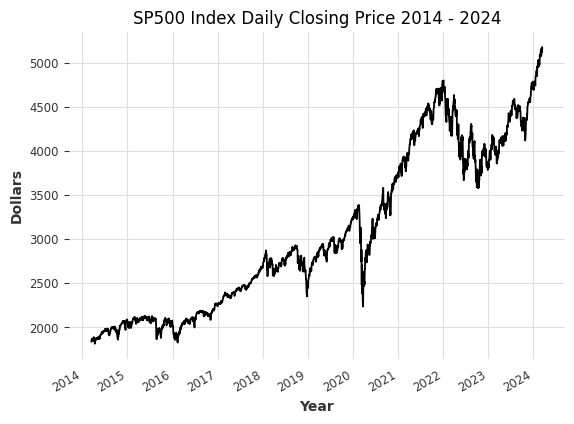

In [6]:
sp500_Index.plot(legend=None)
plt.title('SP500 Index Daily Closing Price 2014 - 2024')
plt.ylabel('Dollars'); plt.xlabel('Year');

Check maximumn date (index) value within data set

In [7]:
sp500_Index.idxmax()

sp   2024-03-12
dtype: datetime64[ns]

### Calculate and Visualize Drawdown for Context
---

In [8]:
sp500_daily_returns = sp500_Index[['sp']].pct_change()
#sp500_daily_returns.head()

In [9]:
sp500_cumulative_returns = (1 + sp500_daily_returns).cumprod()
sp500_cumulative_max = sp500_cumulative_returns.cummax()
sp500_drawdown = (sp500_cumulative_returns-sp500_cumulative_max) / sp500_cumulative_max
#sp500_drawdown.head()

<Figure size 1000x600 with 0 Axes>

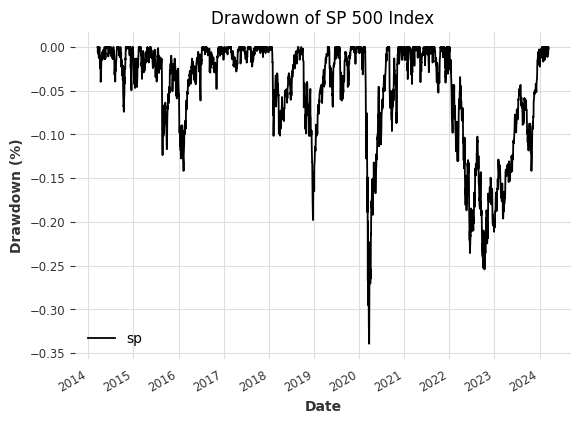

In [10]:
plt.figure(figsize=(10,6))
sp500_drawdown.plot(label='SP 500 2014 - 2024 Drawdown')
plt.title('Drawdown of SP 500 Index')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.legend()
plt.show()

In [32]:
def maxdrawdown(ds):
    previousPeaks = ds.cummax()
    drawdown = (ds-previousPeaks)/previousPeaks
    return '%.2f' % (drawdown.min()*100) + '%', drawdown.idxmin()

In [33]:
maxdrawdown(sp500_cumulative_returns)

('-33.92%',
 sp   2020-03-23
 dtype: datetime64[ns])

### Decomposition
---

We decompose the time series to assess potential trend, cyclical, and seasonal components.  Decomposition improves our understanding of the series and provides valuable insight when defining our forecasting models.


STL decomposition(Season and Trend decomposition using Loess), handles any manner of seasonality, while also controlling for any potential trend.

In [12]:
seasonalTrendLoess_IDX = STL(sp500_Index['sp'], period=52)
result = seasonalTrendLoess_IDX.fit()
trend = result.trend
seasonal = result.seasonal
residual = result.resid

In [13]:
fig = go.Figure()

fig = sp.make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=['Original', 'Trend', 'Seasonal', 'Residual'], vertical_spacing=0.05)
fig.add_trace(go.Scatter(x=sp500_Index.index, y=sp500_Index['sp'], mode='lines', name='Original'), row=1, col=1)
fig.add_trace(go.Scatter(x=sp500_Index.index, y=trend, mode='lines', name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(x=sp500_Index.index, y=seasonal, mode='lines', name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=sp500_Index.index, y=residual, mode='lines', name='Residual'), row=4, col=1)

fig.update_layout(title_text='STL Decomposition of S&P500', showlegend=False, height=1300)

fig.show()

We can recognize an obvious trend component in the time serires but no clear seasonal aspect.

## Time Series Data Management
---

In [14]:
ts_sp500idx = TimeSeries.from_dataframe(sp500_Index[['sp']], freq='D')
ts_sp500idx.head()

<TimeSeries (DataArray) (date: 5, component: 1, sample: 1)> Size: 40B
array([[[1841.13]],

       [[    nan]],

       [[    nan]],

       [[1858.83]],

       [[1872.25]]])
Coordinates:
  * date       (date) datetime64[ns] 40B 2014-03-14 2014-03-15 ... 2014-03-18
  * component  (component) object 8B 'sp'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<AxesSubplot: xlabel='date'>

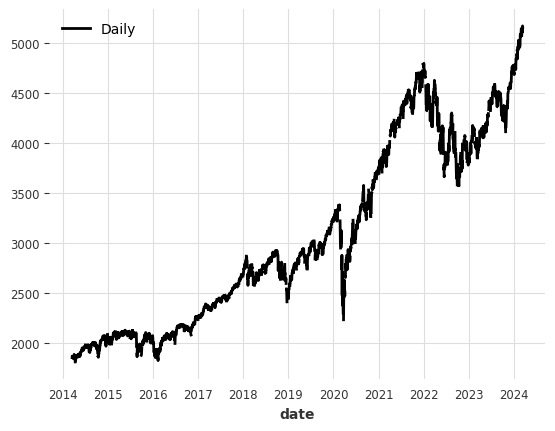

In [15]:
ts_sp500idx.plot(label="Daily")

Missing values are present within the daily time series, due to weekends and other holidays, when markets are closed.  We will resample our time series at a weekly period to remove the issue of missing values.

### Weekly Re-sampling
---

<AxesSubplot: xlabel='week'>

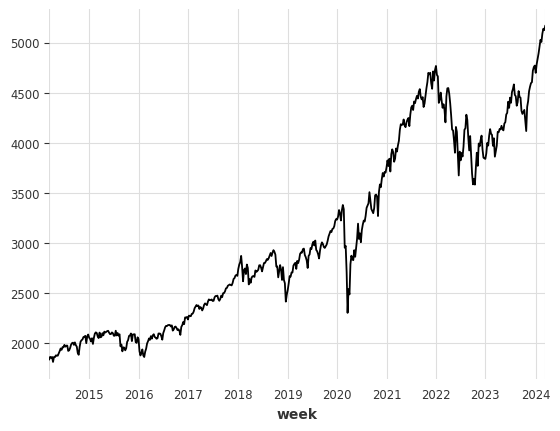

In [16]:
sp500_weekly = sp500_Index\
    .resample('W')\
    .last()
sp500_weekly.index.rename('week', inplace=True)
sp500_weekly

# now the quarterly means
sp500_weekly.plot(legend=None)

In [17]:
ts_sp500idx_wk = TimeSeries.from_dataframe(sp500_weekly[['sp']], freq='W')
ts_sp500idx_wk.head()

<TimeSeries (DataArray) (week: 5, component: 1, sample: 1)> Size: 40B
array([[[1841.13]],

       [[1866.52]],

       [[1857.62]],

       [[1865.09]],

       [[1815.69]]])
Coordinates:
  * week       (week) datetime64[ns] 40B 2014-03-16 2014-03-23 ... 2014-04-13
  * component  (component) object 8B 'sp'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### Spilt Data for Training and Validation
---

We split our data up into training and validation sets:

* **training data:** data to fit our model. 
* **validation data:** data to estimate model performance.

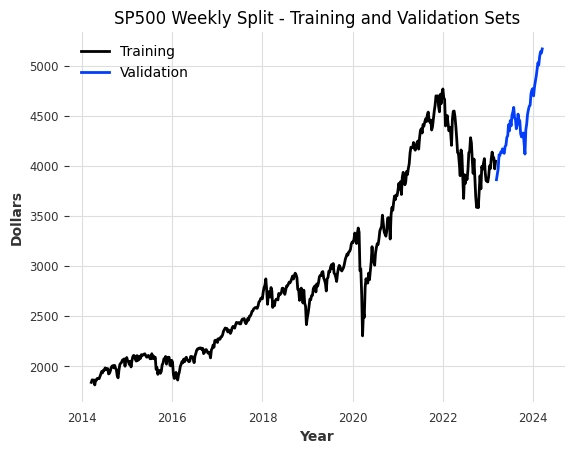

In [18]:
split_date = "2023-03-12"
train, val = ts_sp500idx_wk.split_before(pd.Timestamp(split_date))
train.plot(label="Training")
val.plot(label="Validation")
plt.title('SP500 Weekly Split - Training and Validation Sets')
plt.xlabel('Year'); plt.ylabel('Dollars');

### Helper Functions

- Visualizations
- Error Tracking
---

In [19]:
def plot_results(title, fcasts, subtitle=''):
    plt.figure(figsize=(12,4))
    train.plot(label="Training Data")
    val.plot(label="Validation Data", color='lightgrey')
    fcasts.plot(label="Forecast", low_quantile=0.05, high_quantile=0.95)
    plt.suptitle(title, fontsize=14)
    if subtitle != '': 
        plt.title(subtitle, fontsize=10)
    plt.xlabel(''); plt.ylabel('Dollars');

In [20]:
def add_errors(df, fcast, mod_name):
    mae1 = mae(actual_series=val, pred_series=fcast)
    rmse1 = rmse(actual_series=val, pred_series=fcast)
    mape1 = mape(actual_series=val, pred_series=fcast)
    df_temp = pd.DataFrame({'mad':[mae1], 
                            'rmse':[rmse1],
                            'mape':[mape1]},
                           index=[mod_name])
    df = pd.concat([df, df_temp])
    return df

### Simple Naive Forecasting
---

In [21]:
num_fcasts = sp500_weekly.loc[split_date:].shape[0]
num_fcasts

54

In [22]:
#### define and fit model
mod = NaiveSeasonal(K=1)
mod.fit(train)

#### get forecast/predictions
fcast = mod.predict(num_fcasts)

In [23]:
mae1 = mae(actual_series=val, pred_series=fcast)
rmse1 = rmse(actual_series=val, pred_series=fcast)
mape1 = mape(actual_series=val, pred_series=fcast)
mase1 = mase(actual_series=val, 
             pred_series=val,
            insample=train)


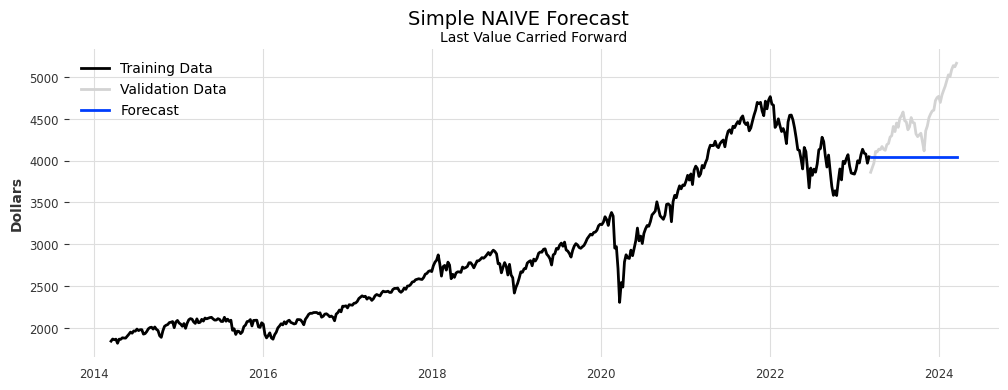

In [24]:
plot_results("Simple NAIVE Forecast", fcast, "Last Value Carried Forward")

Estimate Simple Naive model performance.

In [25]:
df_results = pd.DataFrame({'mad':[mae1], 'rmse':[rmse1], 'mape':[mape1]},
                          index=['NAIVE'])
df_results

,mad,rmse,mape
NAIVE,442.951296,536.445107,9.486809


### Naive Forecasting with Drift Function
---

In [26]:
modDrift = NaiveDrift()
modDrift.fit(train)

#### get forecast/predictions
fcast = modDrift.predict(num_fcasts)

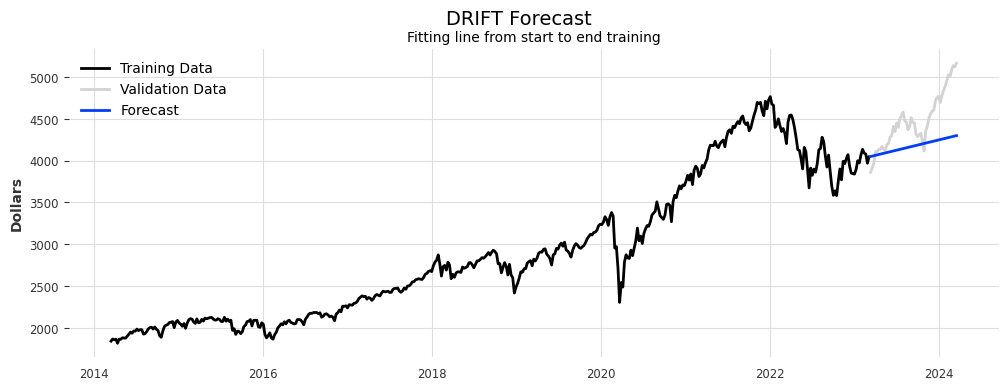

In [27]:
plot_results("DRIFT Forecast", fcast, "Fitting line from start to end training")

Estimate and track Naive with Drift function model performance.

In [28]:
df_results = add_errors(df_results, fcast, 'DRIFT')
df_results

,mad,rmse,mape
NAIVE,442.951296,536.445107,9.486809
DRIFT,317.734621,396.053269,6.786437


### ARIMA
---

In [29]:
#### define and fit model
mod_arima2 = ARIMA(p=52, d=1, q=1)
mod_arima2.fit(train)

#### get forecast/predictions
# if this is taking a while to run, reduce num_samples to ~100
fcast_arima2 = mod_arima2.predict(num_fcasts, num_samples=100)

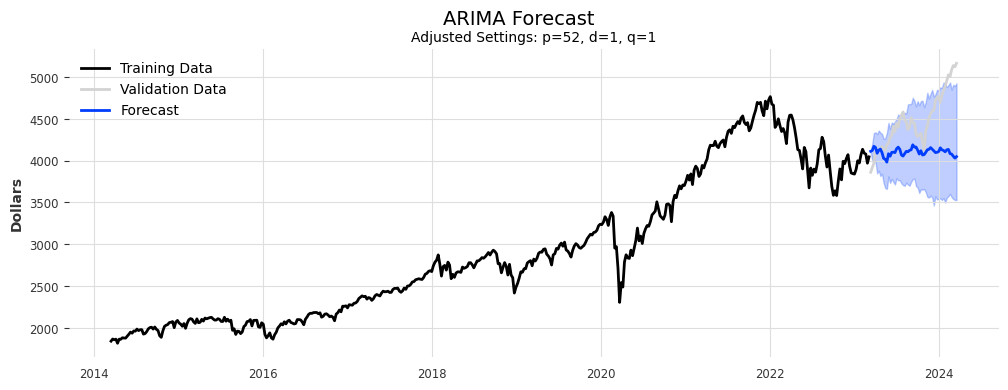

In [30]:
params = mod_arima2.model_params
plot_results("ARIMA Forecast", 
             fcast_arima2, 
             f"Adjusted Settings: p={params['p']}, d={params['d']}, q={params['q']}")

Estimate and track ARIMA Forecast model performance.

In [31]:
df_results = add_errors(df_results, fcast_arima2, 'ARIMA')
df_results

,mad,rmse,mape
NAIVE,442.951296,536.445107,9.486809
DRIFT,317.734621,396.053269,6.786437
ARIMA,394.269958,493.275650,8.422921


### Exponential Smoothing with Trend Component
---

In [32]:
mod_etl = ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE, seasonal=SeasonalityMode.NONE)
mod_etl.fit(train)

#### get forecast/predictions
fcast_etl = mod_etl.predict(num_fcasts, num_samples=100)

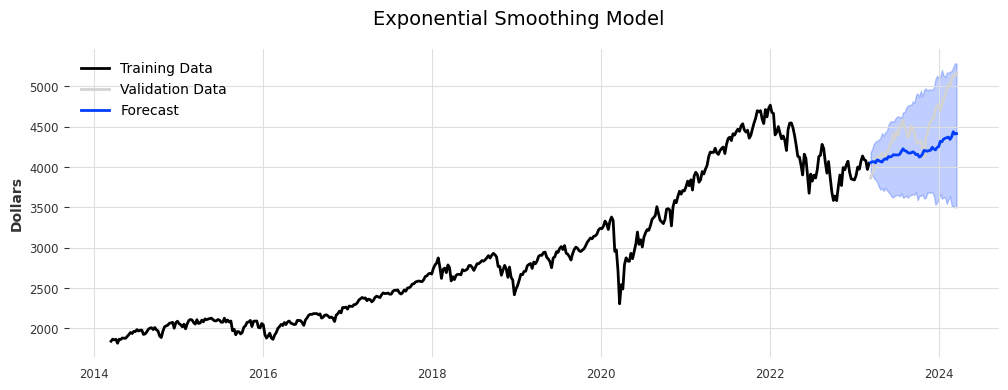

In [33]:
plot_results("Exponential Smoothing Model", fcast_etl)

Estimate and track Exponential Smoothing model performance.

In [34]:
df_results = add_errors(df_results, fcast_etl, 'ETL')
df_results

,mad,rmse,mape
NAIVE,442.951296,536.445107,9.486809
DRIFT,317.734621,396.053269,6.786437
ARIMA,394.269958,493.275650,8.422921
ETL,296.973982,359.243067,6.369862


### Prophet Model Forecasting
---

### Basic Prophet Model

In [35]:
#### define and fit model
mod_prophet = Prophet()
mod_prophet.fit(train)

#### get forecast/predictions
fcast_prophet = mod_prophet.predict(num_fcasts, num_samples=100)

09:33:53 - cmdstanpy - INFO - Chain [1] start processing
09:33:53 - cmdstanpy - INFO - Chain [1] done processing


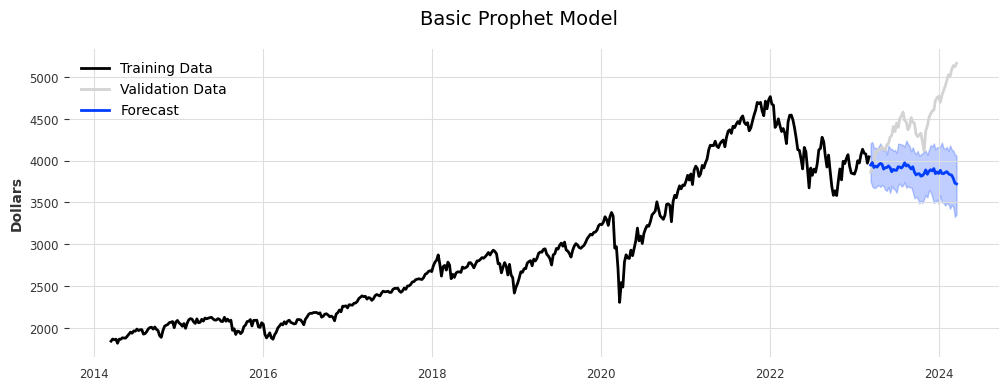

In [36]:
plot_results("Basic Prophet Model", fcast_prophet)

Estimate and track Basic Prophet model performance.

In [37]:
df_results = add_errors(df_results, fcast_prophet, 'PROPHET Basic')
df_results

,mad,rmse,mape
NAIVE,442.951296,536.445107,9.486809
DRIFT,317.734621,396.053269,6.786437
ARIMA,394.269958,493.275650,8.422921
ETL,296.973982,359.243067,6.369862
PROPHET Basic,595.286904,691.393296,12.825960


### Prophet Linear Growth Model

In [38]:
mod_prophet.model.growth
mod_prophet2 = Prophet(growth='linear')
mod_prophet2.fit(train)

#### get forecast/predictions
fcast_prophet2 = mod_prophet2.predict(num_fcasts, num_samples=100)

09:33:54 - cmdstanpy - INFO - Chain [1] start processing
09:33:54 - cmdstanpy - INFO - Chain [1] done processing


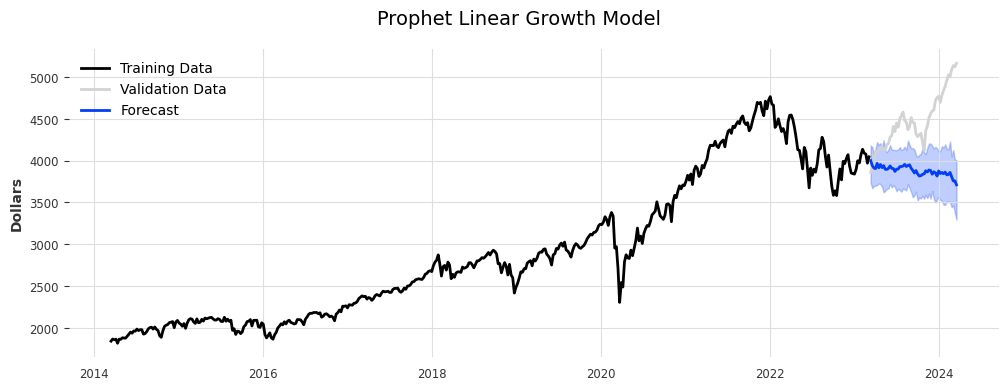

In [39]:
plot_results("Prophet Linear Growth Model", fcast_prophet2)

Estimate and track Prophet Linear Growth model performance.

In [40]:
df_results = add_errors(df_results, fcast_prophet2, 'PROPHET Linear')
df_results

,mad,rmse,mape
NAIVE,442.951296,536.445107,9.486809
DRIFT,317.734621,396.053269,6.786437
ARIMA,394.269958,493.275650,8.422921
ETL,296.973982,359.243067,6.369862
PROPHET Basic,595.286904,691.393296,12.825960
PROPHET Linear,599.261053,695.482027,12.913791


### Compute Tracking Signal and Compare Metrics
---

In [41]:
df_results["TS"] = df_results["rmse"] / df_results["mad"]
df_results

,mad,rmse,mape,TS
NAIVE,442.951296,536.445107,9.486809,1.211070
DRIFT,317.734621,396.053269,6.786437,1.246491
ARIMA,394.269958,493.275650,8.422921,1.251111
ETL,296.973982,359.243067,6.369862,1.209679
PROPHET Basic,595.286904,691.393296,12.825960,1.161446
PROPHET Linear,599.261053,695.482027,12.913791,1.160566


### Would leveraging only more recent data improve performance?
---

In [42]:
split_date6yr = "2017-03-12"
hist_train, train_6yr = train.split_before(pd.Timestamp(split_date6yr))
#train_6yr

In [43]:
# build a function to plot 6 year result with forecasts
def plot_results_6yr(title, fcasts, subtitle=''):
    plt.figure(figsize=(12,4))
    train_6yr.plot(label="Training Data")
    val.plot(label="Validation Data", color='lightgrey')
    fcasts.plot(label="Forecast", low_quantile=0.05, high_quantile=0.95)
    plt.suptitle(title, fontsize=14)
    if subtitle != '': 
        plt.title(subtitle, fontsize=10)
    plt.xlabel(''); plt.ylabel('Dollars');

### Simple Naive Forecasting - 6 Year
---

In [44]:
#### define and fit model
mod_Naive6yr = NaiveSeasonal(K=1)
mod_Naive6yr.fit(train_6yr)

#### get forecast/predictions
fcast_Naive6yr = mod_Naive6yr.predict(num_fcasts)

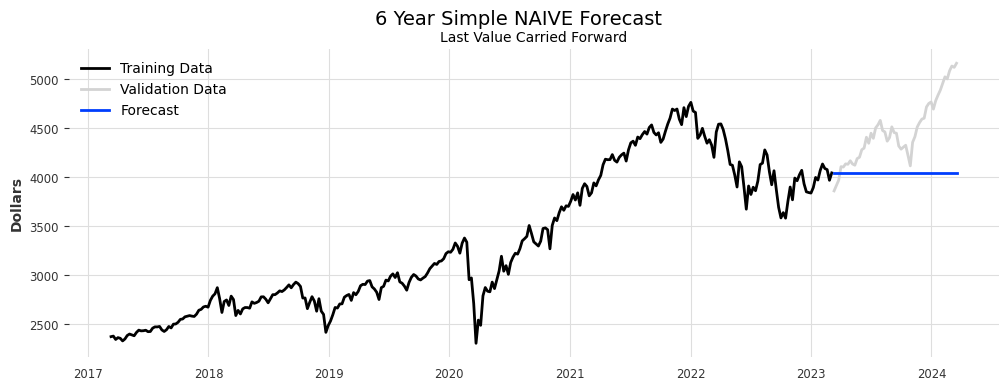

In [45]:
plot_results_6yr("6 Year Simple NAIVE Forecast", fcast_Naive6yr, "Last Value Carried Forward")

In [46]:
mae6yr = mae(actual_series=val, pred_series=fcast_Naive6yr)
rmse6yr = rmse(actual_series=val, pred_series=fcast_Naive6yr)
mape6yr = mape(actual_series=val, pred_series=fcast_Naive6yr)
mase6yr = mase(actual_series=val, 
             pred_series=val,
            insample=train_6yr)

In [47]:
df_results_6yr = pd.DataFrame({'mad':[mae6yr], 'rmse':[rmse6yr], 'mape':[mape6yr]},
                          index=['NAIVE 6 Year'])
df_results_6yr

,mad,rmse,mape
NAIVE 6 Year,442.951296,536.445107,9.486809


### Naive Forecasting with Drift Function - 6 Year
---

In [48]:
modDrift_6yr = NaiveDrift()
modDrift_6yr.fit(train_6yr)

#### get forecast/predictions
fcast_Drift_6yr = modDrift_6yr.predict(num_fcasts)

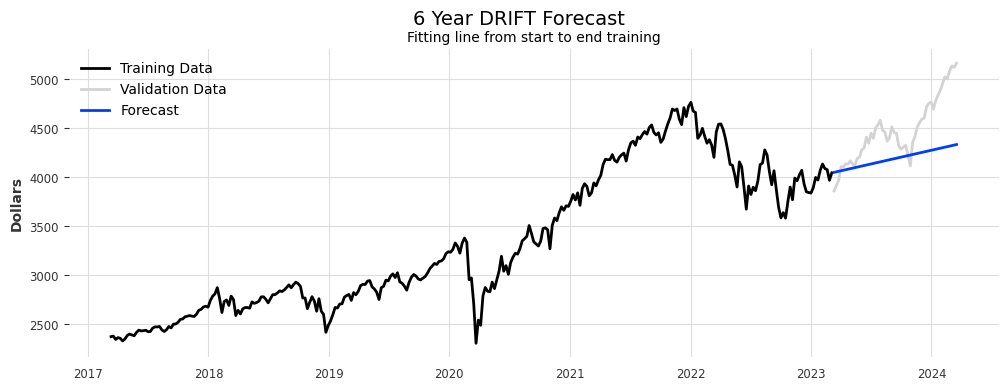

In [49]:
plot_results_6yr("6 Year DRIFT Forecast", fcast_Drift_6yr, "Fitting line from start to end training")

In [50]:
df_results_6yr = add_errors(df_results_6yr, fcast_Drift_6yr, 'DRIFT 6 Year')
df_results_6yr

,mad,rmse,mape
NAIVE 6 Year,442.951296,536.445107,9.486809
DRIFT 6 Year,300.775328,377.140660,6.421700


### ARIMA - 6 Year
---

In [51]:
#### define and fit model
mod_arima6yr = ARIMA(p=52, d=1, q=1)
mod_arima6yr.fit(train_6yr)

#### get forecast/predictions
# if this is taking a while to run, reduce num_samples to ~100
fcast_arima6yr = mod_arima6yr.predict(num_fcasts, num_samples=100)

C:\Users\qjhar\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



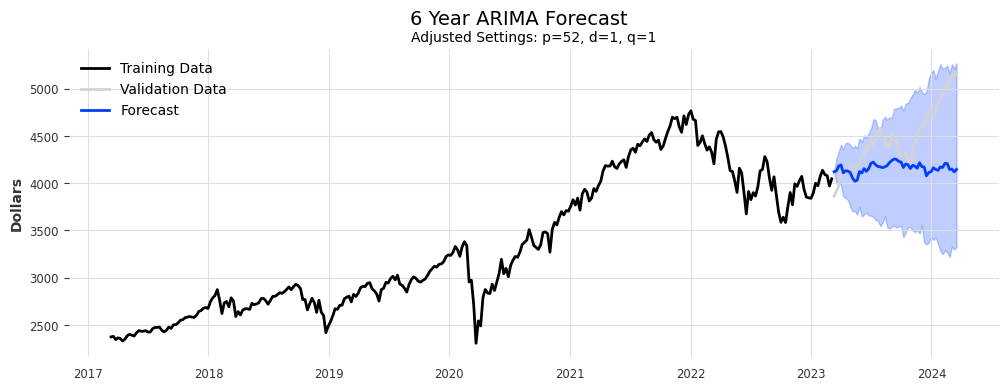

In [52]:
params6yr = mod_arima6yr.model_params
plot_results_6yr("6 Year ARIMA Forecast", 
             fcast_arima6yr, 
             f"Adjusted Settings: p={params6yr['p']}, d={params6yr['d']}, q={params6yr['q']}")

In [53]:
df_results_6yr = add_errors(df_results_6yr, fcast_arima6yr, 'ARIMA 6 Year')
df_results_6yr

,mad,rmse,mape
NAIVE 6 Year,442.951296,536.445107,9.486809
DRIFT 6 Year,300.775328,377.140660,6.421700
ARIMA 6 Year,343.735586,447.814653,7.312587


### Exponential Smoothing with Trend Component - 6 Year
---

In [54]:
mod_etl_6yr = ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE, seasonal=SeasonalityMode.NONE)
mod_etl_6yr.fit(train_6yr)

#### get forecast/predictions
fcast_etl_6yr = mod_etl_6yr.predict(num_fcasts, num_samples=100)

C:\Users\qjhar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning:

overflow encountered in matmul



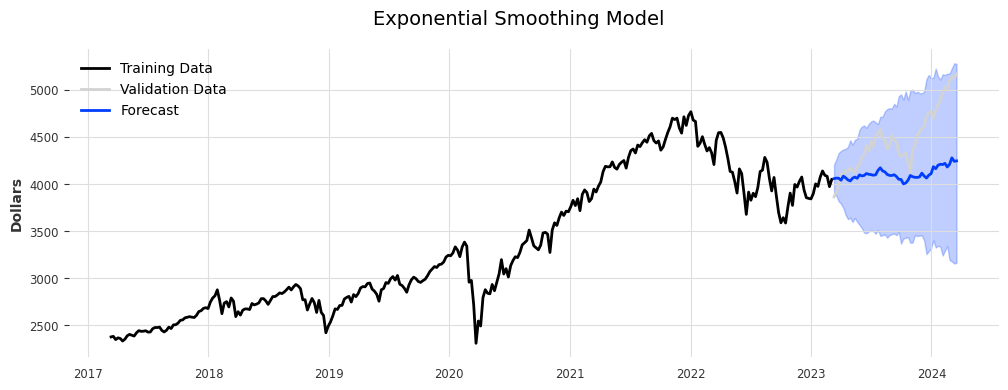

In [55]:
plot_results_6yr("Exponential Smoothing Model", fcast_etl_6yr)

In [56]:
df_results_6yr = add_errors(df_results_6yr, fcast_etl_6yr, 'ETL 6 Year')
df_results_6yr

,mad,rmse,mape
NAIVE 6 Year,442.951296,536.445107,9.486809
DRIFT 6 Year,300.775328,377.140660,6.421700
ARIMA 6 Year,343.735586,447.814653,7.312587
ETL 6 Year,384.688047,458.616955,8.262592


### Prophet Model Forecasting - 6 Year
---

In [57]:
mod_prophet.model.growth
mod_prophet6yr = Prophet(growth='linear')
mod_prophet6yr.fit(train_6yr)

#### get forecast/predictions
fcast_prophet6yr = mod_prophet6yr.predict(num_fcasts, num_samples=100)

09:34:32 - cmdstanpy - INFO - Chain [1] start processing
09:34:32 - cmdstanpy - INFO - Chain [1] done processing


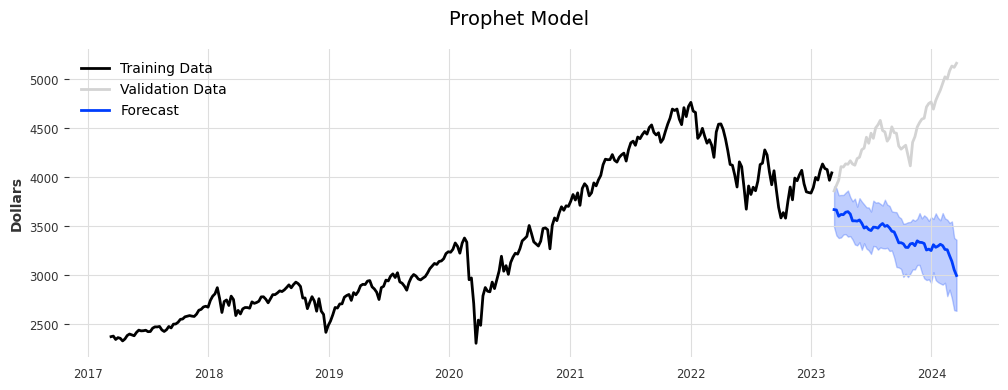

In [58]:
plot_results_6yr("Prophet Model", fcast_prophet6yr)

In [59]:
df_results_6yr = add_errors(df_results_6yr, fcast_prophet6yr, 'PROPHET 6 Year')
df_results_6yr

,mad,rmse,mape
NAIVE 6 Year,442.951296,536.445107,9.486809
DRIFT 6 Year,300.775328,377.140660,6.421700
ARIMA 6 Year,343.735586,447.814653,7.312587
ETL 6 Year,384.688047,458.616955,8.262592
PROPHET 6 Year,1065.239757,1159.458588,23.220695


### Compute Tracking Signal and Compare Metrics - 6 Year
---

In [60]:
df_results_6yr["TS"] = df_results_6yr["rmse"] / df_results_6yr["mad"]
df_results_6yr

,mad,rmse,mape,TS
NAIVE 6 Year,442.951296,536.445107,9.486809,1.211070
DRIFT 6 Year,300.775328,377.140660,6.421700,1.253895
ARIMA 6 Year,343.735586,447.814653,7.312587,1.302788
ETL 6 Year,384.688047,458.616955,8.262592,1.192179
PROPHET 6 Year,1065.239757,1159.458588,23.220695,1.088448


### Would forecasting a shorter period improve performance?
---

Split data to forecast one quarter forward (12 weeks) instead of one year.

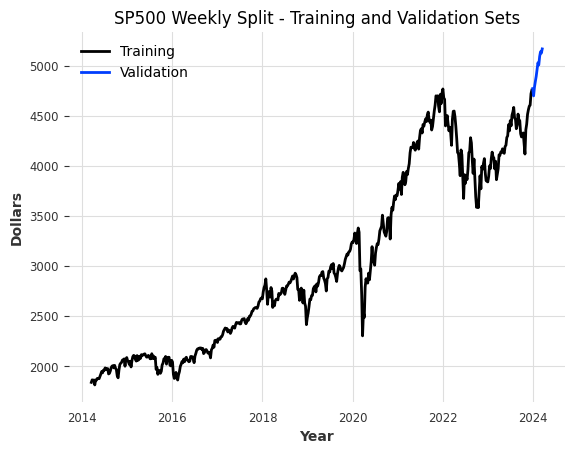

In [61]:
split_date30 = "2023-12-31"
train30, val30 = ts_sp500idx_wk.split_before(pd.Timestamp(split_date30))
train30.plot(label="Training")
val30.plot(label="Validation")
plt.title('SP500 Weekly Split - Training and Validation Sets')
plt.xlabel('Year'); plt.ylabel('Dollars');

In [62]:
# function to add error results to results DF
def add_errors_1qtr(df, fcast, mod_name):
    mae1 = mae(actual_series=val30, pred_series=fcast)
    rmse1 = rmse(actual_series=val30, pred_series=fcast)
    mape1 = mape(actual_series=val30, pred_series=fcast)
    df_temp = pd.DataFrame({'mad':[mae1], 
                            'rmse':[rmse1],
                            'mape':[mape1]},
                           index=[mod_name])
    df = pd.concat([df, df_temp])
    return df

In [63]:
num_fcasts30 = sp500_weekly.loc[split_date30:].shape[0]
num_fcasts30

12

### ARIMA - 1 Quarter Forecast
---

In [64]:
#### define and fit model
mod_arima30 = ARIMA(p=52, d=1, q=1)
mod_arima30.fit(train30)

#### get forecast/predictions
# if this is taking a while to run, reduce num_samples to ~100
fcast_arima30 = mod_arima30.predict(num_fcasts30, num_samples=100)

C:\Users\qjhar\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



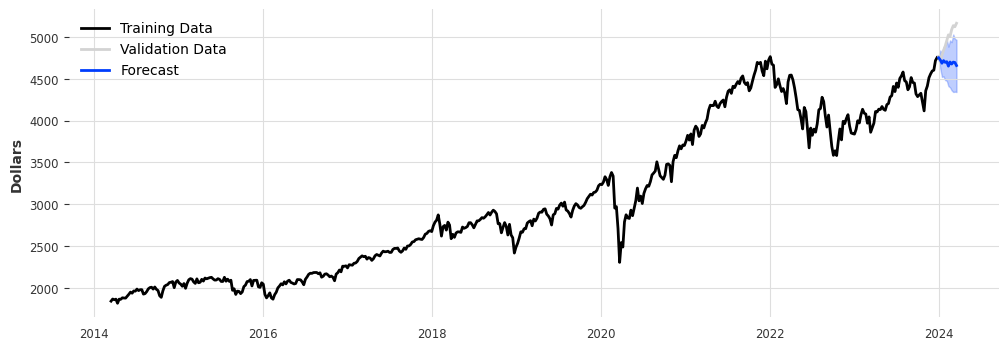

In [65]:
plt.figure(figsize=(12,4))
train30.plot(label="Training Data")
val30.plot(label="Validation Data", color='lightgrey')
fcast_arima30.plot(label="Forecast", low_quantile=0.05, high_quantile=0.95)
#plt.suptitle(title, fontsize=14)
plt.xlabel(''); plt.ylabel('Dollars');

In [66]:
df_results_1qtr = pd.DataFrame(columns=['mad' ,'rmse', 'mape'])
df_results_1qtr

,mad,rmse,mape


In [67]:
df_results_1qtr = add_errors_1qtr(df_results_1qtr, fcast_arima30, 'ARIMA 1 Qtr')
df_results_1qtr

,mad,rmse,mape
ARIMA 1 Qtr,263.901107,310.341731,5.227722


### Exponential Smoothing with Trend Component - 1 Quarter Forecast
---

In [68]:
mod_etl_1qtr = ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE, seasonal=SeasonalityMode.NONE)
mod_etl_1qtr.fit(train30)

#### get forecast/predictions
fcast_etl_1qtr = mod_etl_1qtr.predict(num_fcasts30, num_samples=100)

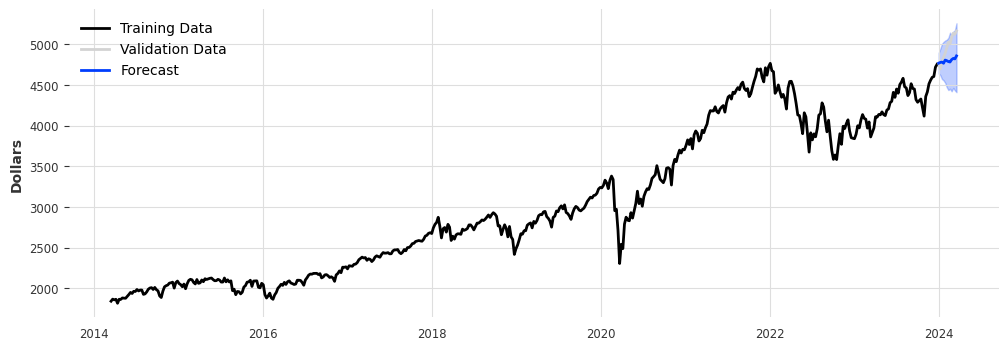

In [69]:
plt.figure(figsize=(12,4))
train30.plot(label="Training Data")
val30.plot(label="Validation Data", color='lightgrey')
fcast_etl_1qtr.plot(label="Forecast", low_quantile=0.05, high_quantile=0.95)
#plt.suptitle(title, fontsize=14)
plt.xlabel(''); plt.ylabel('Dollars');

In [70]:
df_results_1qtr = add_errors_1qtr(df_results_1qtr, fcast_etl_1qtr, 'Exponential Smoothing 1 Qtr')
df_results_1qtr

,mad,rmse,mape
ARIMA 1 Qtr,263.901107,310.341731,5.227722
Exponential Smoothing 1 Qtr,171.562416,206.079049,3.396598


### Prophet Model Forecasting - 1 Quarter
---

In [71]:
mod_prophet.model.growth
mod_prophet_1qtr = Prophet(growth='linear')
mod_prophet_1qtr.fit(train30)

#### get forecast/predictions
fcast_prophet_1qtr = mod_prophet_1qtr.predict(num_fcasts30, num_samples=100)

09:35:20 - cmdstanpy - INFO - Chain [1] start processing
09:35:20 - cmdstanpy - INFO - Chain [1] done processing


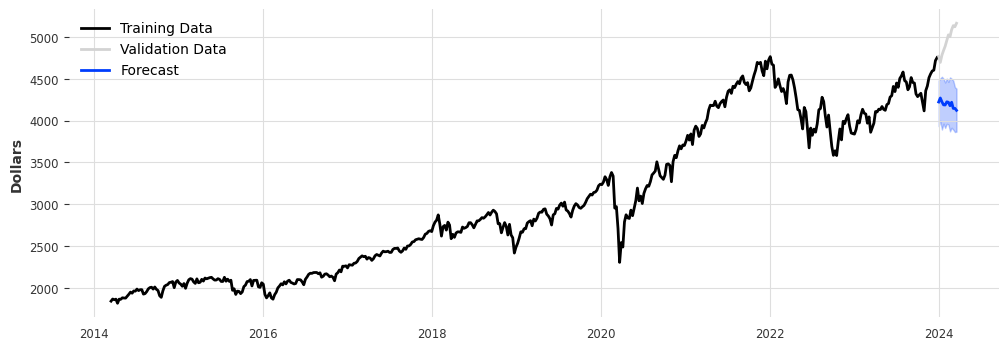

In [72]:
plt.figure(figsize=(12,4))
train30.plot(label="Training Data")
val30.plot(label="Validation Data", color='lightgrey')
fcast_prophet_1qtr.plot(label="Forecast", low_quantile=0.05, high_quantile=0.95)
#plt.suptitle(title, fontsize=14)
plt.xlabel(''); plt.ylabel('Dollars');

In [73]:
df_results_1qtr = add_errors_1qtr(df_results_1qtr, fcast_prophet_1qtr, 'PROPHET 1 Qtr')
df_results_1qtr

,mad,rmse,mape
ARIMA 1 Qtr,263.901107,310.341731,5.227722
Exponential Smoothing 1 Qtr,171.562416,206.079049,3.396598
PROPHET 1 Qtr,760.513098,782.721228,15.241438


### Compute Tracking Signal and Compare Metrics - 1 Quarter Forecasts
---

In [74]:
df_results_1qtr["TS"] = df_results_1qtr["rmse"] / df_results_1qtr["mad"]
df_results_1qtr

,mad,rmse,mape,TS
ARIMA 1 Qtr,263.901107,310.341731,5.227722,1.175977
Exponential Smoothing 1 Qtr,171.562416,206.079049,3.396598,1.201190
PROPHET 1 Qtr,760.513098,782.721228,15.241438,1.029202


In [75]:
Results = pd.concat([df_results, df_results_6yr , df_results_1qtr], axis=0, ignore_index=False)
Results

,mad,rmse,mape,TS
NAIVE,442.951296,536.445107,9.486809,1.211070
DRIFT,317.734621,396.053269,6.786437,1.246491
ARIMA,394.269958,493.275650,8.422921,1.251111
ETL,296.973982,359.243067,6.369862,1.209679
PROPHET Basic,595.286904,691.393296,12.825960,1.161446
PROPHET Linear,599.261053,695.482027,12.913791,1.160566
NAIVE 6 Year,442.951296,536.445107,9.486809,1.211070
DRIFT 6 Year,300.775328,377.140660,6.421700,1.253895
ARIMA 6 Year,343.735586,447.814653,7.312587,1.302788
ETL 6 Year,384.688047,458.616955,8.262592,1.192179


## Conclusions
---
The goal of this analysis was not only to forecast stock prices but to ultimately understand the underlying factors that influence these prices.  

Through decomposition, we could detect the trend component present within the series, however, there was little evidence of apparent seasonal or cyclical components to the data set.

We leveraged naive forecasting methods to establish baseline performance metrics to evaluate more complex approaches.  We also evaluated model performance with a smaller historical data set and smaller forecasting window.

While all of the calculated tracking signals fall within an acceptable range, none of the models do a great job modeling the reality of the magnitude of movements and randomness contained within the S&P 500 index price data set during the forecasted period. Exponential Smoothing with trend and ARIMA forecasts leveraging the full training data set provided the best measured performance considering all factors, including number of forecasted predictions.   These specific forecasts were superior to the other models but not particularly close to the actual values. However, the range of potential probable values reported by the ETL and ARIMA forecasts did appear to approximate the potential magnitude of movements present within the actual data.  

This insight could give an investor a probable price range the index is forecasted to be trading within for a future period.  This is potentially very valuable information. Given updated data, current S&P 500 price, recent price movements information, and other contextual details, investment decisions could be planned accordingly.
